In [2]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from google.colab import drive

# Monto Google Drive en el entorno de Google Colab
drive.mount('/content/drive')

# Defino un punto de control para guardar el modelo
checkpoint_path = '/content/drive/My Drive/Checkpoints/model_checkpoint_resnet.h5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Crear el modelo base ResNet50 preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas adicionales para la clasificación binaria
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

# Configurar generadores de datos para el entrenamiento
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset_2/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset_2/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Entrenar el modelo
epochs = 10

history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator , callbacks=[checkpoint], initial_epoch=0)

Found 7302 images belonging to 2 classes.
Found 1825 images belonging to 2 classes.
Epoch 1/10
457/457 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5744

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


457/457 [==============================] - 178s 361ms/step - loss: 0.6955 - accuracy: 0.5744 - val_loss: 0.6872 - val_accuracy: 0.5578
Epoch 2/10
457/457 [==============================] - 101s 220ms/step - loss: 0.6200 - accuracy: 0.6710 - val_loss: 0.6965 - val_accuracy: 0.5644
Epoch 3/10
457/457 [==============================] - 102s 224ms/step - loss: 0.5970 - accuracy: 0.6917 - val_loss: 0.6745 - val_accuracy: 0.6186
Epoch 4/10
457/457 [==============================] - 102s 224ms/step - loss: 0.5815 - accuracy: 0.7031 - val_loss: 0.6678 - val_accuracy: 0.6186
Epoch 5/10
457/457 [==============================] - 101s 222ms/step - loss: 0.5699 - accuracy: 0.7162 - val_loss: 0.6670 - val_accuracy: 0.6532
Epoch 6/10
457/457 [==============================] - 102s 223ms/step - loss: 0.5568 - accuracy: 0.7251 - val_loss: 0.6440 - val_accuracy: 0.6553
Epoch 7/10
457/457 [==============================] - 103s 225ms/step - loss: 0.5509 - accuracy: 0.7264 - val_loss: 0.6385 - val_accura

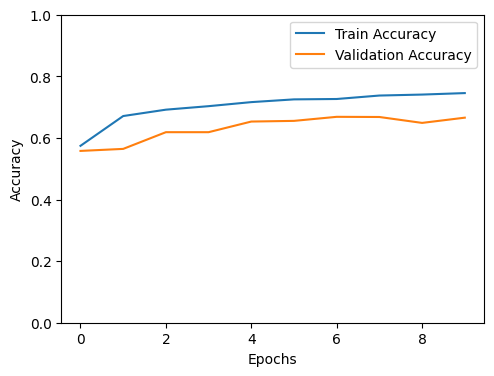

In [4]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Graficar las curvas de precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
#Guardo el modelo
model.save('/content/drive/MyDrive/Saved_model_resnet')
model.save('/content/drive/MyDrive//Saved_model_resnet/mi_modelo_resnet.keras')

In [ ]:
#Cargo el modelo
modelo_cargado = load_model('/content/drive/MyDrive/mi_modelo_resnet.keras')

In [9]:
#Defino función de predicción
def prediccion(modelo,imagen,treshold):

    # Reshape para que coincida con el formato de entrada del modelo

     nueva_altura = 224
     nuevo_ancho = 224

     h, w = imagen.shape[:2]

    # Calcular el nuevo tamaño manteniendo la relación de aspecto original
     if h < w:
          nueva_altura_temp = int(nueva_altura * (h / w))
          nuevo_ancho_temp = nuevo_ancho
     else:
          nueva_altura_temp = nueva_altura
          nuevo_ancho_temp = int(nuevo_ancho * (w / h))

     imagen_redimensionada = cv2.resize(imagen,(nuevo_ancho_temp , nueva_altura_temp))

     imagen_redimensionada = imagen_redimensionada / 255.0

     # Crear una imagen en blanco del tamaño objetivo
     imagen_final = np.zeros((nueva_altura, nuevo_ancho, 3), dtype=np.uint8)

     # Calcular las coordenadas para copiar la imagen redimensionada en el centro
     y_offset = (nueva_altura - nueva_altura_temp) // 2
     x_offset = (nuevo_ancho - nuevo_ancho_temp) // 2

     # Copiar la región redimensionada en la ubicación calculada
     imagen_final[y_offset:y_offset + nueva_altura_temp, x_offset:x_offset + nuevo_ancho_temp] = imagen_redimensionada

     imagen_final = np.expand_dims(imagen_final, axis=0)


     # Realizar predicciones
     prediccion_imagen = modelo.predict(imagen_final)

     if prediccion_imagen > treshold:
          print(prediccion_imagen)
          return "La persona tiene sueño"
     else:
          print(prediccion_imagen)
          return "La persona no tiene sueño"



1/1 [==============================] - 0s 28ms/step
[[0.8375984]]


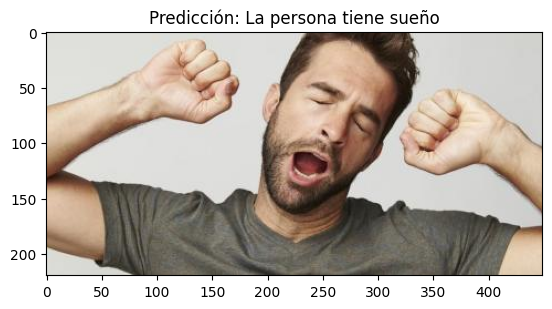

1/1 [==============================] - 0s 25ms/step
[[0.8375984]]


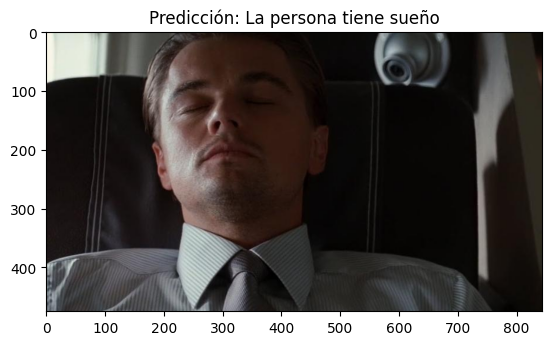

1/1 [==============================] - 0s 26ms/step
[[0.83729935]]


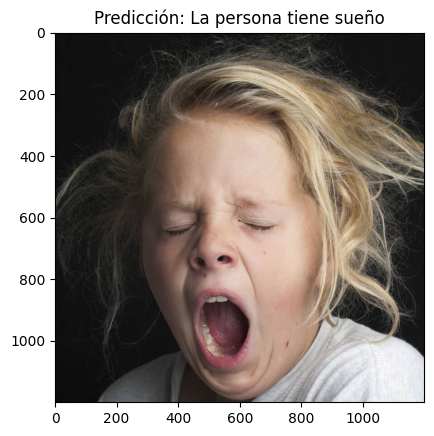

1/1 [==============================] - 0s 25ms/step
[[0.51743704]]


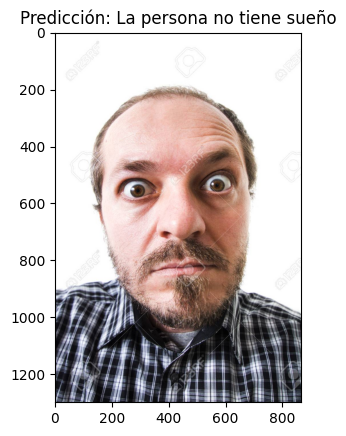

1/1 [==============================] - 0s 24ms/step
[[0.8710718]]


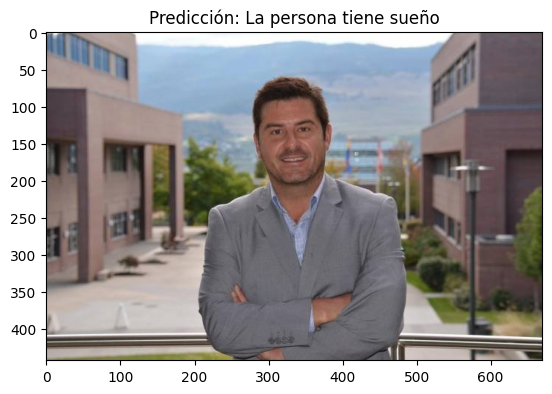

In [10]:
#Cargo imágenes a testear

# Directorio en Google Drive que contiene las imágenes
directorio_drive = '/content/drive/My Drive/Imágenes de prueba/Con sueño'

# Obtener la lista de nombres de archivos en el directorio
nombres_archivos = os.listdir(directorio_drive)

# Filtrar solo los archivos de imagen (puedes ajustar según los tipos de archivos que tengas)
extensiones_imagen = ['.jpg', '.jpeg', '.png']
rutas_imagenes = [os.path.join(directorio_drive, archivo) for archivo in nombres_archivos if any(archivo.lower().endswith(ext) for ext in extensiones_imagen)]

imagenes = [cv2.imread(ruta) for ruta in rutas_imagenes]

#Realizo predicciones
for imagen, ruta in zip(imagenes, rutas_imagenes):
    # Realizar la predicción
    pred = prediccion(model, imagen, 0.8)
    # Mostrar la imagen con el resultado de la predicción
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicción: {pred}')
    plt.show()